In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import statsmodels.api as sm


/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Scenario

You go to the casino one night with \\$5000 and decide roulette is your game of choice. You get a little into it and play 500 rounds. Little did you know your probability of winning is 48.5%

For simplicity, we'll simply assume that you bet \\$100 each round, and if you win you earn 2x your bet, if you lose you lose that \$100 you put down

We'll start by simulating some data in python. Let's see what happens after playing 500 rounds

In [2]:
SEED = 6

pWin = 0.485
bet_amt = 100
initial = 5000
hands = 100000

In [3]:
np.random.seed(SEED)

wins = np.random.binomial(1, pWin,size=hands)
results = np.where(wins==1, bet_amt, -bet_amt)
total_money = initial + results.cumsum()
print("Peaking at the data: ")
total_money[:10]

Peaking at the data: 


array([5100, 5000, 5100, 5000, 4900, 5000, 5100, 5000, 4900, 5000])

Text(0.5, 0, 'Number of Rounds')

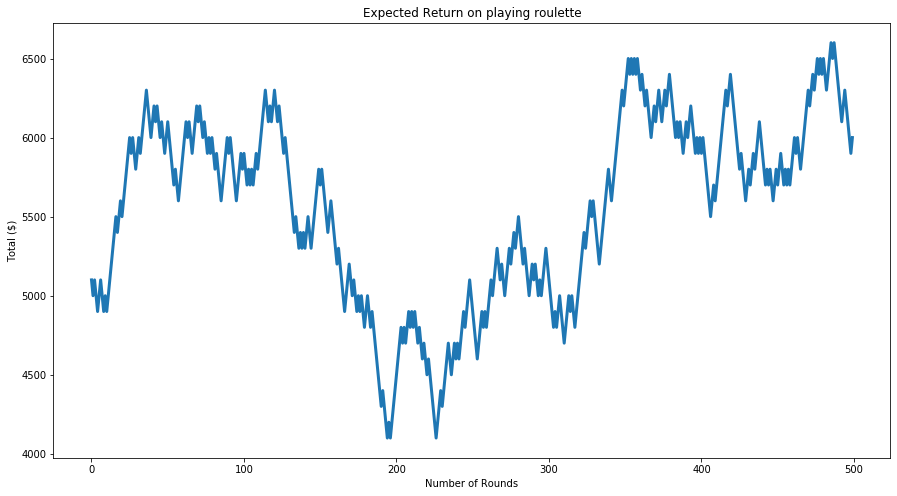

In [4]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(total_money[:500], lw=3)
ax.set_title("Expected Return on playing roulette")
ax.set_ylabel("Total ($)")
ax.set_xlabel("Number of Rounds")

In [5]:
return_after_500_rounds = total_money[:500][-1]
print("Total Money after 500 rounds: ${}".format(return_after_500_rounds))
print("Pct Return after 500 rounds: {:.0%}".format(return_after_500_rounds/initial))
print("Winning Percentage: {:.1%}".format(wins[:500].mean()))


Total Money after 500 rounds: $6000
Pct Return after 500 rounds: 120%
Winning Percentage: 51.0%


This is great - after 500 rounds of this you've made 122% return on your initial investment of \\$5000 and you're winning 51% of the time

Commited to your sterategy you decide to come back for the next few weeks and play another 3000 rounds

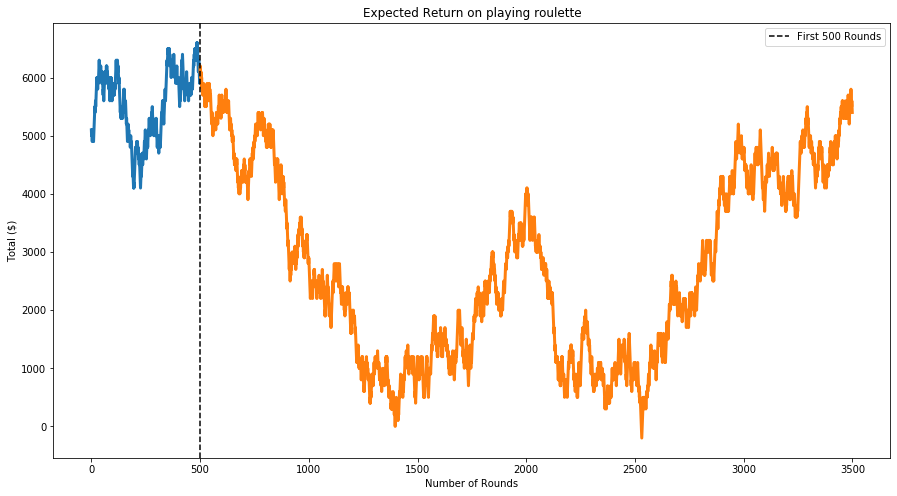

In [6]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(total_money[:500], lw=3)
ax.plot(range(500,3500), total_money[500:3500], lw=3, color="C1")

ax.set_title("Expected Return on playing roulette")
ax.set_ylabel("Total ($)")
ax.set_xlabel("Number of Rounds")
ax.axvline(500, color="k", ls="--", label="First 500 Rounds")
plt.legend();

In [7]:
print("Total Money after 3500 rounds: ${}".format(total_money[:3500][-1]))
print("Pct Return after 3500 rounds: {:.0%}".format(total_money[:3500][-1]/initial))
print("Winning Percentage: {:.1%}".format(wins[:3500].mean()))


Total Money after 3500 rounds: $5400
Pct Return after 3500 rounds: 108%
Winning Percentage: 50.1%


Alright we've played 3500 rounds now and we've definitely had some runs of bad luck, but we're still seeing a win percentage above 50% and right now we're heating up. We stay determined and play until we reach 15000 rounds

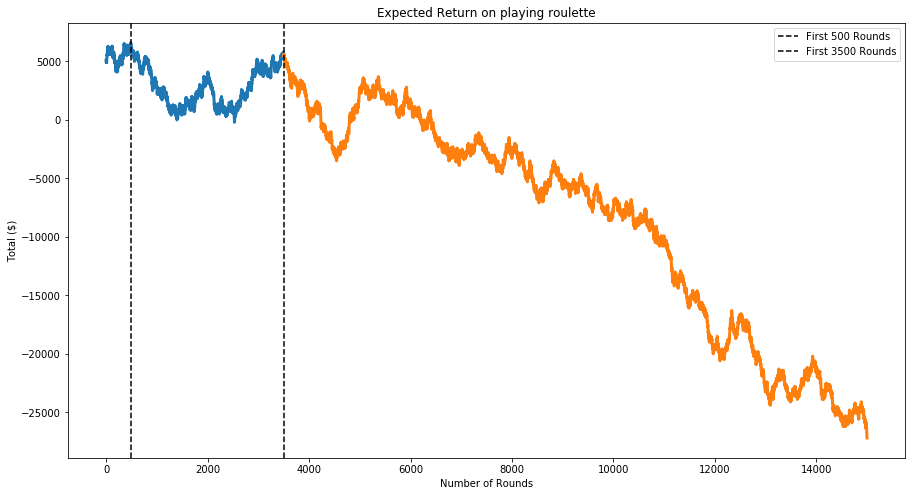

In [8]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(total_money[:500], lw=3)
ax.plot(range(500,3500), total_money[500:3500], lw=3, color="C0")
ax.plot(range(3500,15000), total_money[3500:15000], lw=3, color="C1")

ax.set_title("Expected Return on playing roulette")
ax.set_ylabel("Total ($)")
ax.set_xlabel("Number of Rounds")
ax.axvline(500, color="k", ls="--", label="First 500 Rounds")
ax.axvline(3500, color="k", ls="--", label="First 3500 Rounds")

plt.legend();

In [9]:
return_after_15k_rounds = total_money[:15000][-1]
print("Total Money after 15000 rounds: ${}".format(return_after_15k_rounds))
print("Pct Return after 15000 rounds: {:.0%}".format(return_after_15k_rounds/initial))

Total Money after 15000 rounds: $-27200
Pct Return after 15000 rounds: -544%


# What happened?
We started off on a hot streak winning 51% of our rounds, but as we played more and more rounds, it became more obvious we were losing money. This is a demonstration of the law of large numbers - as we play more and more rounds, the truth comes out

We can visualize this process via the distribution below. These plots visualize all of the possible values that the true win percentage could be (the x axis), and their relative plausibilities (the y axis). The first plot can be read as follows: 
```
The win percentage is likely to be somewhere between 42.5% and 60%, with the most likely value being around 51%
```

In [10]:
def beta_est(a, N,ax):
    b = N-a
    dist = np.random.beta(a,b,size=4000)
    sns.histplot(dist,ax=ax, stat="probability", element="step")
    ax.set_title(f"Estimated Win percentage\nafter {N} rounds")
    ax.set_xlabel("Win Percentage")
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1))

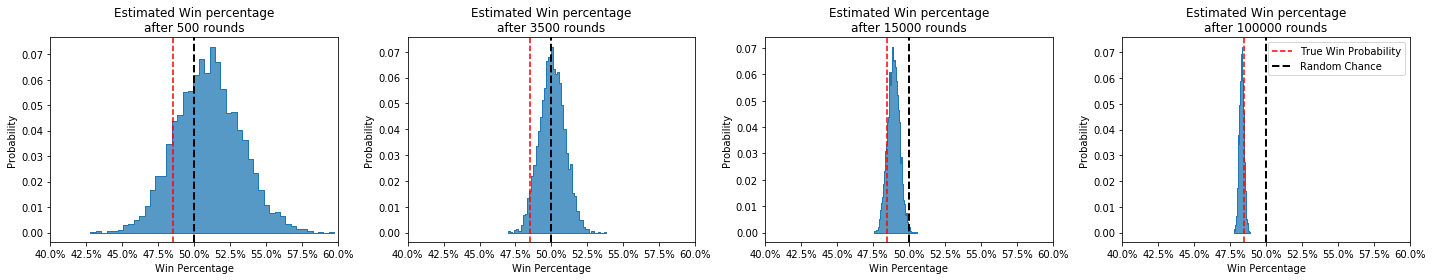

In [11]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
beta_est( wins[:500].sum(), 500, ax=ax[0])
beta_est( wins[:3500].sum(), 3500,ax=ax[1])
beta_est( wins[:15000].sum(), 15000,ax=ax[2])
beta_est( wins[:100000].sum(), 100000,ax=ax[3])
for i in range(4):
    ax[i].set_xlim(0.4, .6)
    ax[i].axvline(pWin, color="red", ls="--", label="True Win Probability")
    ax[i].axvline(0.5, color="k", ls="--", lw=2, label="Random Chance")
plt.legend()
plt.tight_layout()

As we move from left to right, our estimated distribution converges closer and closer to the true probability of winning a round

# How does this relate to A/B testing?

If we don't choose our sample size for an experiment properly, we can end up making the wrong decisions! The larger the sample size we choose, the more likely we'll make the right choice.

Analysts can use __power analyses__ (sometimes referred to as simulation studies) to estimate what sample size is needed for an experiment given the desired outcome